In [1]:
import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
import pandas as pd
import matplotlib.pyplot as plt
import ROOT
from collections import defaultdict
ROOT.gSystem.Load("/nevis/tehanu/data/st3624/software/GRAMS/GramsSim-work/libDictionary.so")

plt.style.use('~/latex-cm.mplstyle')


import seaborn as sns
colors = sns.color_palette('colorblind')

In [2]:
# info about which sim we are working with
location = 'tucson'
date = '2025_8_31'
maps_dir = f'/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/{location}_{date}_maps'

In [3]:
# setup particle dictionary: {'GramsSim particle name:' ['proper particle name', 'PDG', particle_mass_in_MeV]}
particle_dict = {'neutro':['Neutron', '2112', 939.565], 
                 'proton':['Proton', '2212', 938.272], 
                 'he---4':['Helium-4','1000020040', 3727.38], 
                 'muplus':['$\\mu^+$','-13', 105.66], 
                 'mumins': ['$\\mu^-$','13', 105.66], 
                 'electr':['Electron', '11', 0.511], 
                 'positr':['Positron', '-11', 0.511], 
                 'photon': ['Photon', '22', 0]}

In [4]:
# load in g4 output files for all particles
def load_particle_trees(location, particles, maps_dir, tree_name="gramsg4"):
    files = {}
    trees = {}

    for p in particles:
        path = f"{maps_dir}/sim/{location}_{p}_g4.root"
        f = ROOT.TFile.Open(path)
        if not f or f.IsZombie():
            print(f"[WARN] Failed to open: {path}")
            files[p] = None
            trees[p] = None
            continue

        #  fetch by file handle
        t = f.Get(tree_name)
        if not t or not isinstance(t, ROOT.TTree):
            print(f"[WARN] '{tree_name}' not found or not a TTree in: {path}")
            files[p] = f
            trees[p] = None
            continue

        print(f"[OK] {p:>6}: {tree_name} with {t.GetEntries()} entries from {path}")
        files[p] = f
        trees[p] = t

    return files, trees


In [5]:
files, trees = load_particle_trees(location, particle_dict.keys(), maps_dir)

[OK] neutro: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_neutro_g4.root
[OK] proton: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_proton_g4.root
[OK] he---4: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_he---4_g4.root
[OK] muplus: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_muplus_g4.root
[OK] mumins: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_mumins_g4.root
[OK] electr: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_electr_g4.root
[OK] positr: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucso

In [6]:
primary_energies = []
total_scint_photons = []
total_cer_photons = []

particle = 'photon'
tree = trees[particle] # or whichever particle you are analyzing

for entry in tree:
    # 1. Find Primary ID and Energy
    primary_id = None
    primary_E0 = None

    for trackID, track in tree.TrackList:
        if track.Process() == "Primary":
            primary_id = trackID
            traj = track.Trajectory()
            if len(traj) > 0:
                primary_E0 = traj[0].momentum.E()
            break

    if primary_id is None or primary_E0 is None:
        continue

    # 2. Skip event if it didn't produce any hits
    if tree.LArHits.size() == 0:
        continue

    # 3. Sum photons from all hits in this event
    cer_sum = 0 
    scint_sum = 0
    
    # Iterate over the map. key is tuple, hit is grams::MCLArHit
    for key, hit in tree.LArHits:
        cer_sum += hit.cerPhotons
        scint_sum += hit.numPhotons

    # 4. Store the results paired with the primary energy
    primary_energies.append(primary_E0)
    total_cer_photons.append(cer_sum)
    total_scint_photons.append(scint_sum)

print(f"Extracted photon data for {len(primary_energies)} events.")


Extracted photon data for 2523 events.


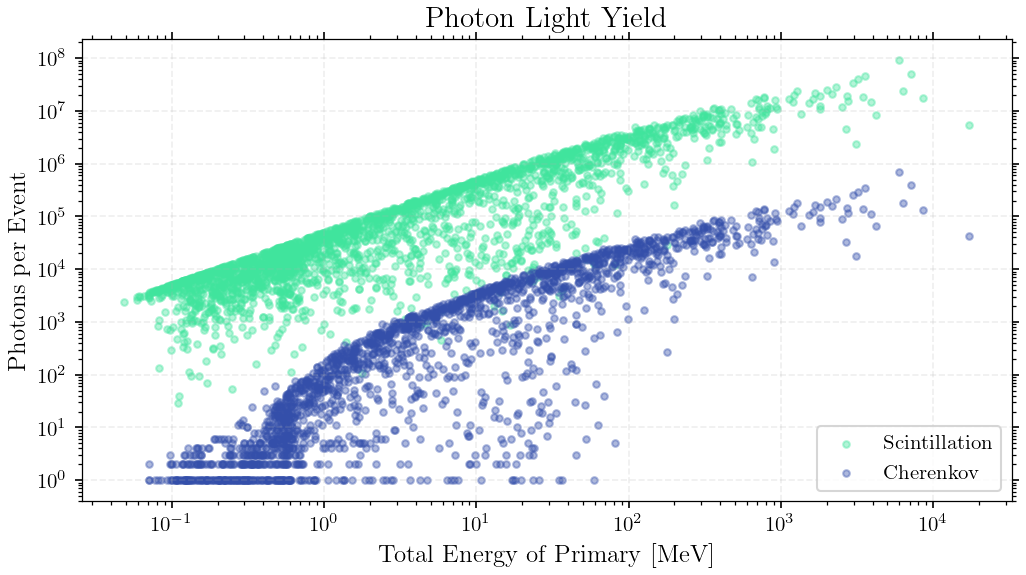

In [7]:
plt.figure(figsize=(8, 4))

# Scatter plot for Scintillation light
plt.scatter(primary_energies, total_scint_photons, 
            alpha=0.4, s=10, label='Scintillation', color="#40E49D")
# Scatter plot for Cherenkov
plt.scatter(primary_energies, total_cer_photons, 
            alpha=0.4, s=10, label='Cherenkov', color="#344FAA")



plt.xscale('log')
plt.yscale('log')
plt.xlabel("Total Energy of Primary [MeV]")
plt.ylabel("Photons per Event")
plt.title(f"{particle_dict[particle][0]} Light Yield")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.2)
plt.show()


In [8]:
# import ROOT
# from collections import defaultdict

# # Configuration
# all_particles_to_process = [
#     'photon', 'proton', 'he---4', 'neutro', 
#     'muplus', 'mumins', 'electr', 'positr'
# ]

# # Dictionary to store results: 
# # photon_data['particle_name'] = {'energy': [], 'scint': [], 'cer': []}
# photon_data = {}

# print("Starting Photon Count Extraction...")

# for particle in all_particles_to_process:
#     if particle not in trees:
#         print(f"Skipping {particle} (Tree not found)")
#         continue
        
#     print(f"Processing {particle}...")
#     tree = trees[particle]
    
#     # Temporary lists for this particle
#     p_energies = []
#     p_scint = []
#     p_cer = []
    
#     for entry in tree:
#         # 1. Find Primary ID and Energy
#         primary_id = None
#         primary_E0 = None

#         for trackID, track in tree.TrackList:
#             if track.Process() == "Primary":
#                 primary_id = trackID
#                 traj = track.Trajectory()
#                 if len(traj) > 0:
#                     primary_E0 = traj[0].momentum.E()
#                 break

#         if primary_id is None or primary_E0 is None:
#             continue

#         # 2. Skip event if it didn't produce any hits
#         if tree.LArHits.size() == 0:
#             continue

#         # 3. Sum photons from all hits in this event
#         cer_sum = 0 
#         scint_sum = 0
        
#         # Iterate over the map. key is tuple, hit is grams::MCLArHit
#         for key, hit in tree.LArHits:
#             cer_sum += hit.cerPhotons
#             scint_sum += hit.numPhotons

#         # 4. Store
#         p_energies.append(primary_E0)
#         p_cer.append(cer_sum)
#         p_scint.append(scint_sum)
        
#     # Save to main dictionary
#     photon_data[particle] = {
#         'energy': p_energies,
#         'scint': p_scint,
#         'cer': p_cer
#     }

# print("Extraction Complete.")


In [9]:
# import pickle

# output_filename = "photon_yield.pkl"

# print(f"Saving photon data to {output_filename}...")
# with open(output_filename, "wb") as f:
#     pickle.dump(photon_data, f)
# print("Save complete!")

In [10]:
import pickle
import os

input_filename = "photon_yield.pkl"

if os.path.exists(input_filename):
    print(f"Loading data from {input_filename}...")
    with open(input_filename, "rb") as f:
        photon_data = pickle.load(f)
    print(f"Load complete! Loaded particles: {list(photon_data.keys())}")
else:
    print(f"Error: {input_filename} not found. You must run the extraction script first.")
    photon_data = {}


Loading data from photon_yield.pkl...
Load complete! Loaded particles: ['photon', 'proton', 'he---4', 'neutro', 'muplus', 'mumins', 'electr', 'positr']


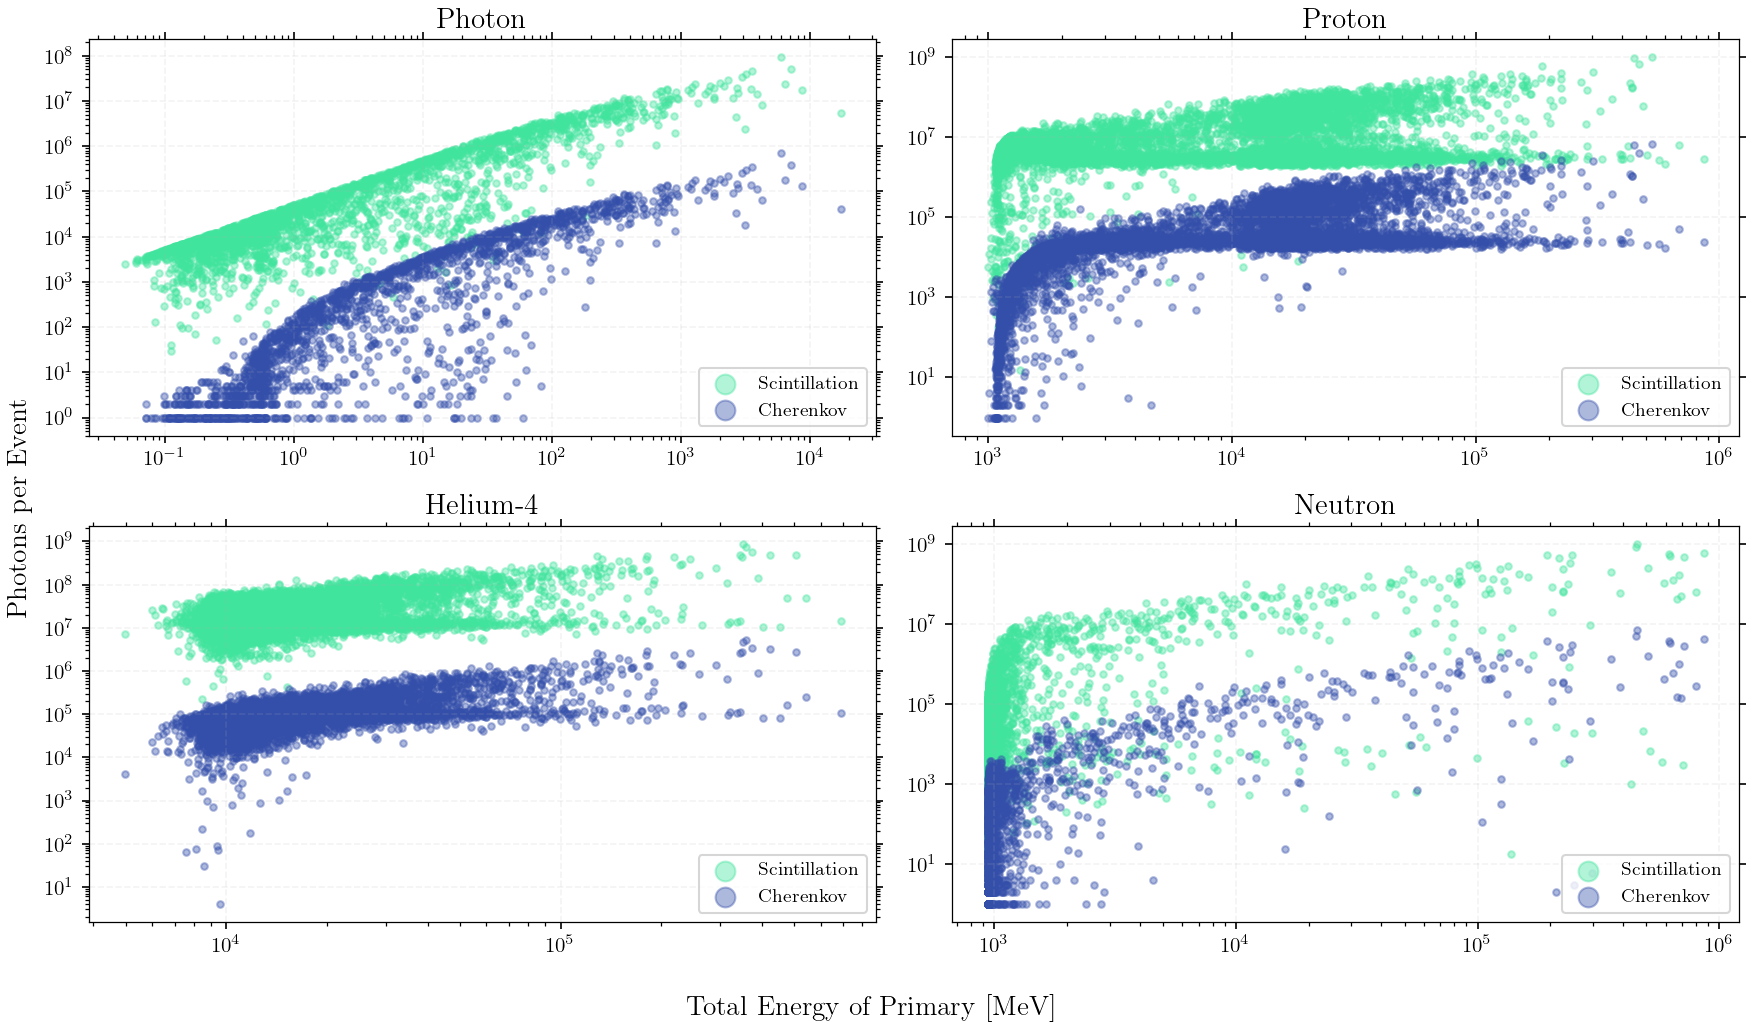

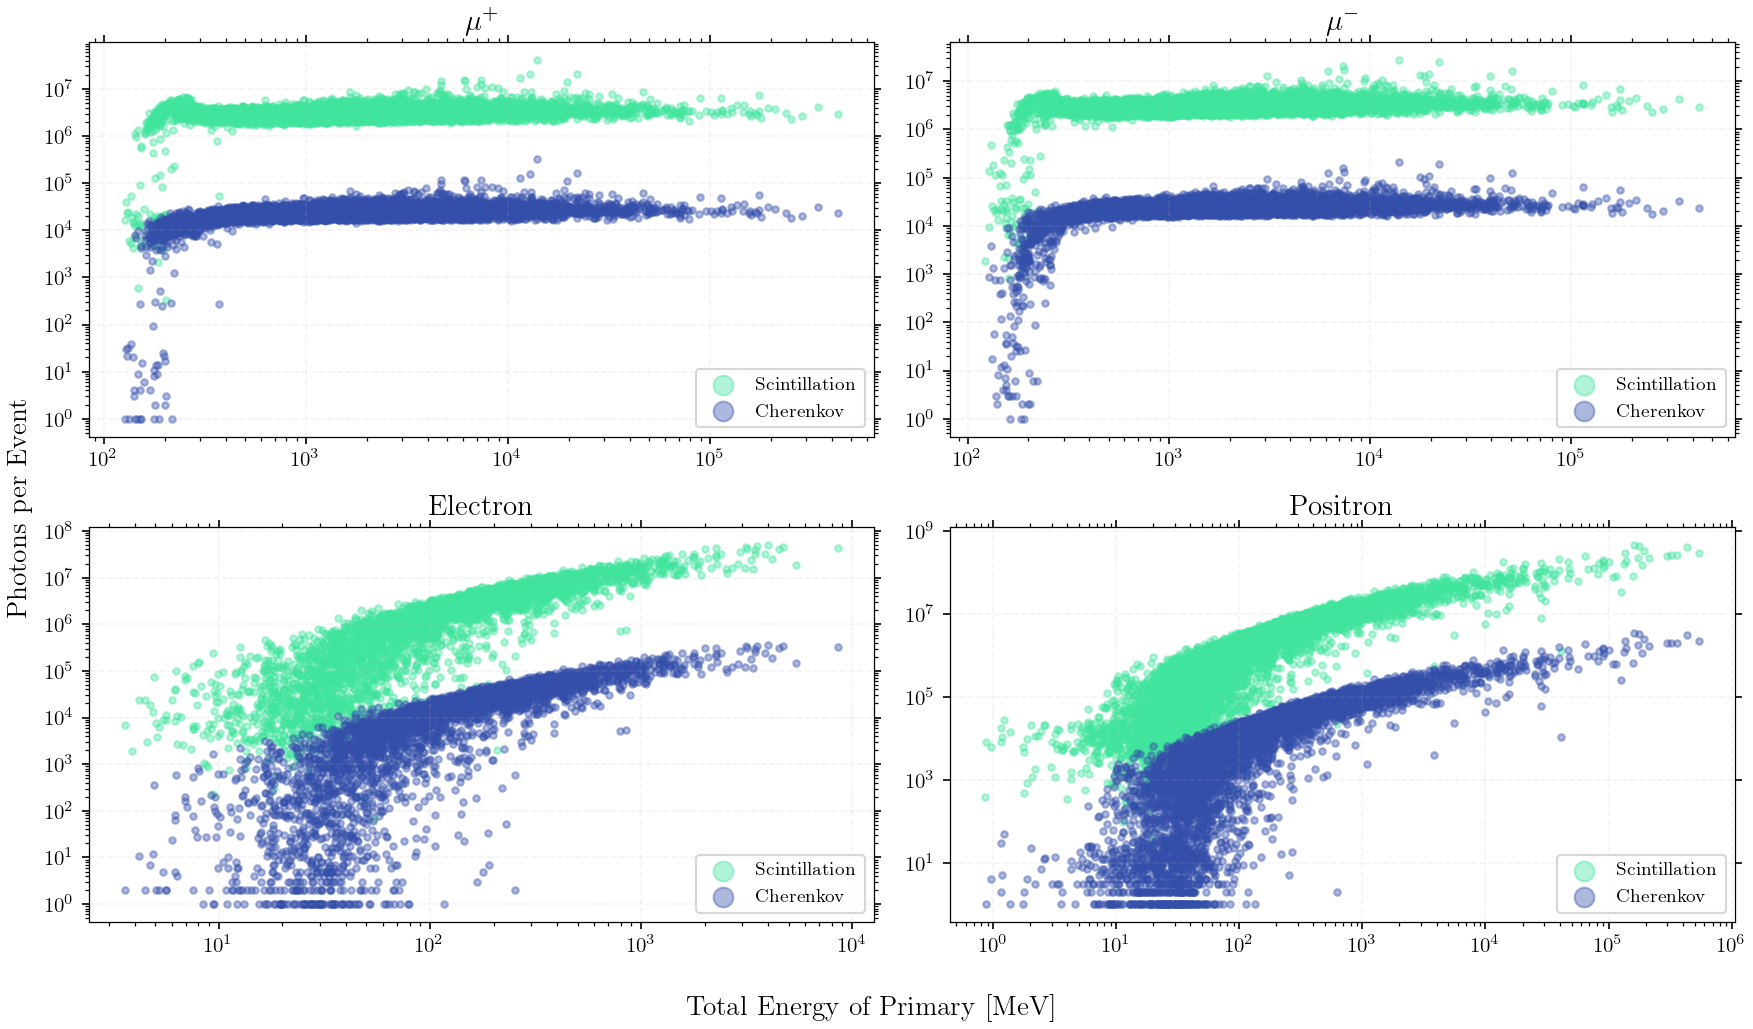

In [11]:
# Groups
group1 = ['photon', 'proton', 'he---4', 'neutro']
group2 = ['muplus', 'mumins', 'electr', 'positr']

particle_names = {
    'neutro': 'Neutron', 'proton': 'Proton', 'he---4': 'Helium-4',
    'muplus': r'$\mu^+$', 'mumins': r'$\mu^-$', 'electr': 'Electron',
    'positr': 'Positron', 'photon': 'Photon'
}

def plot_photon_grid(particle_list, data_source, title):
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes = axes.flatten()

    for ax, p in zip(axes, particle_list):
        data = data_source.get(p, {})
        
        if not data:
            ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes)
            ax.set_title(particle_names.get(p, p))
            continue
            
        energies = data['energy']
        scint = data['scint']
        cer = data['cer']
        
        if not energies:
            ax.text(0.5, 0.5, "No Events", ha='center', transform=ax.transAxes)
            ax.set_title(particle_names.get(p, p))
            continue

        # Scatter Plots
        ax.scatter(energies, scint, alpha=0.4, s=10, 
                   label='Scintillation', color="#40E49D")
        
        ax.scatter(energies, cer, alpha=0.4, s=10, 
                   label='Cherenkov', color="#344FAA")

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(particle_names.get(p, p))
        ax.grid(True, ls="--", alpha=0.15)
        
        # Legend only on the first plot to avoid clutter, or on all if preferred
        # if p == particle_list[0]:
        ax.legend(loc='lower right', fontsize=9, markerscale=3)

    # Set common labels
    fig.supxlabel("Total Energy of Primary [MeV]")
    fig.supylabel("Photons per Event")
    # fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()

# --- Generate Plots ---
plot_photon_grid(group1, photon_data, "Photon Yield")
plot_photon_grid(group2, photon_data, "Photon Yield")


In [12]:
def read_integrated_flux_maps(path: str):
    """
    Read a single-file export of integrated flux maps written by WriteIntegratedFluxMaps.
    
    Returns:
      pixel_idx: (Npix,) int array of pixel indices
      J_bands:   list of length nBands, each element is (Npix,) float array of J_{p,i}
      S:         float, sum over all pixels and bands (cm^-2 s^-1 sr^-1)
    """
    data = np.loadtxt(path, comments="#")
    if data.ndim == 1:
        data = data[np.newaxis, :]

    pixel_idx = data[:, 0].astype(int)
    J_matrix = data[:, 1:]  # shape: (Npix, nBands)
    J_bands = [J_matrix[:, i].copy() for i in range(J_matrix.shape[1])]
    S = sum(float(np.sum(J)) for J in J_bands)
    return pixel_idx, J_bands, S

if particle == 'photon':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_gamma.txt"
elif particle == 'he---4':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_unknown.txt"
elif particle == 'electr':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_e-.txt"
elif particle == 'muplus':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_mu+.txt"
elif particle == 'mumins':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_mu-.txt"
elif particle == 'positr':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_e+.txt"
elif particle == 'neutro':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_neutron.txt"
else:
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_{particle}.txt"

pixel_idx, J_bands, S = read_integrated_flux_maps(path)
print(f"Npix={len(pixel_idx)}, nBands={len(J_bands)}, S={S:.6e} cm^-2 s^-1 sr^-1")


Npix=12288, nBands=79, S=6.904431e+03 cm^-2 s^-1 sr^-1


In [13]:
def theta_phi(px, py, pz):
    p = np.sqrt(px*px + py*py + pz*pz)
    if p == 0: 
        return None, None
    costh = pz/p
    th = np.arccos(np.clip(costh, -1.0, 1.0))
    ph = np.mod(np.arctan2(py, px), 2*np.pi)
    return th, ph

In [14]:
particle = 'photon'
tree = trees[particle] # or whichever particle you are analyzing

# intialize energies_dict; key: event ID, value: total energy deposition
energies_dict = {}
theta_list = []
phi_list = []

# loop through tree and extract energy of primary particles for every event
for entry in tree:
    event = tree.EventID.Index()
    # print("Event ID: ", event)

    energies_dict[event] = 0
    primaries = []
    for trackID, track in tree.TrackList:
        # print(track.PDGCode())
        if track.Process() == "Primary":
            # print(track.Process())
            trajectory = track.Trajectory()
            primary_energy = trajectory[0].momentum.E()
            px, py, pz = trajectory[0].momentum.px(), trajectory[0].momentum.py(), trajectory[0].momentum.pz()
            theta, phi = theta_phi(px, py, pz)
            # print(primary_energy)
            energies_dict[event]=primary_energy
            theta_list.append(theta)
            phi_list.append(phi)

    # print total energy for given event
    # print("Energy for event ", tree.EventID.Index(), ": ", energies_dict[event])


energies = list(energies_dict.values())

# with open("energies.txt", "w") as f:
#     for energy in energies:
#         f.write(str(energy) + "\n")


In [19]:
# weight factor
nside = 32
omega = (4*np.pi)/(12*nside**2) # healpix pixel size in sr
w = S*omega # total number of counts integrated over 1 second, 1 unit area
print('w:', w, 'cm^-2 s^-1')

T = 10000/w

# weights = np.array(weights)/(area*np.array(energies))

w: 7.06084344994344 cm^-2 s^-1


In [20]:
# average area of pGRAMS TPC
area = (2*(30*30)+4*(30*20))/6
print('Total surface area of pGRAMS TPC:', 6*area, 'cm^2')
print('Average Cross-section of pGRAMS TPC:', area, 'cm^2')

Total surface area of pGRAMS TPC: 4200.0 cm^2
Average Cross-section of pGRAMS TPC: 700.0 cm^2


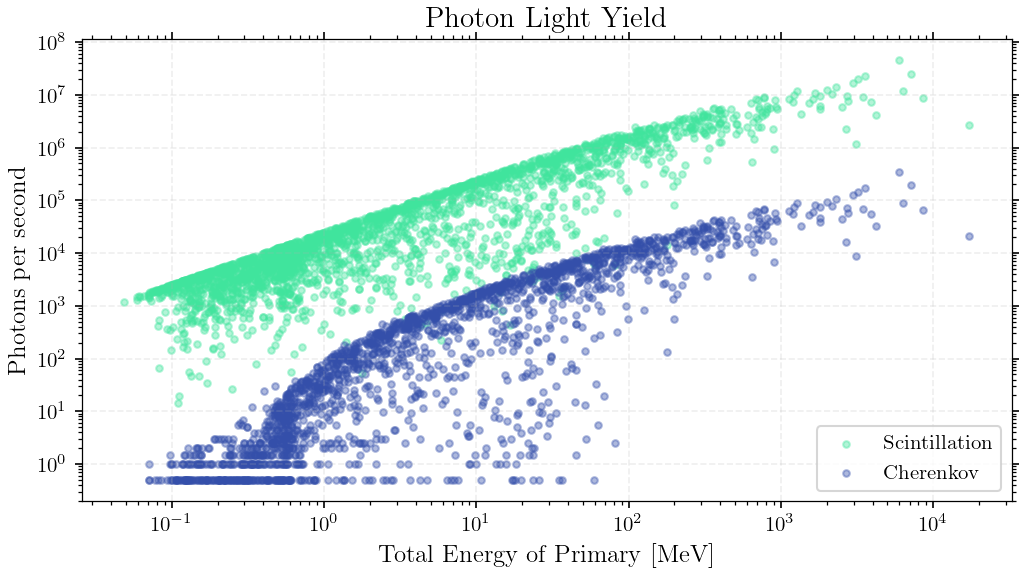

In [23]:
weights = np.full_like(primary_energies, fill_value=1/T, dtype=float)

plt.figure(figsize=(8, 4))

plt.scatter(primary_energies, total_scint_photons * weights * area,
            alpha=0.4, s=10, label='Scintillation', color="#40E49D")

plt.scatter(primary_energies,total_cer_photons * weights * area,
            alpha=0.4, s=10, label='Cherenkov', color="#344FAA")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Total Energy of Primary [MeV]")
plt.ylabel("Photons per second")
plt.title(f"{particle_dict[particle][0]} Light Yield")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.2)
plt.show()


In [27]:
weight_value

0.49425904149604083

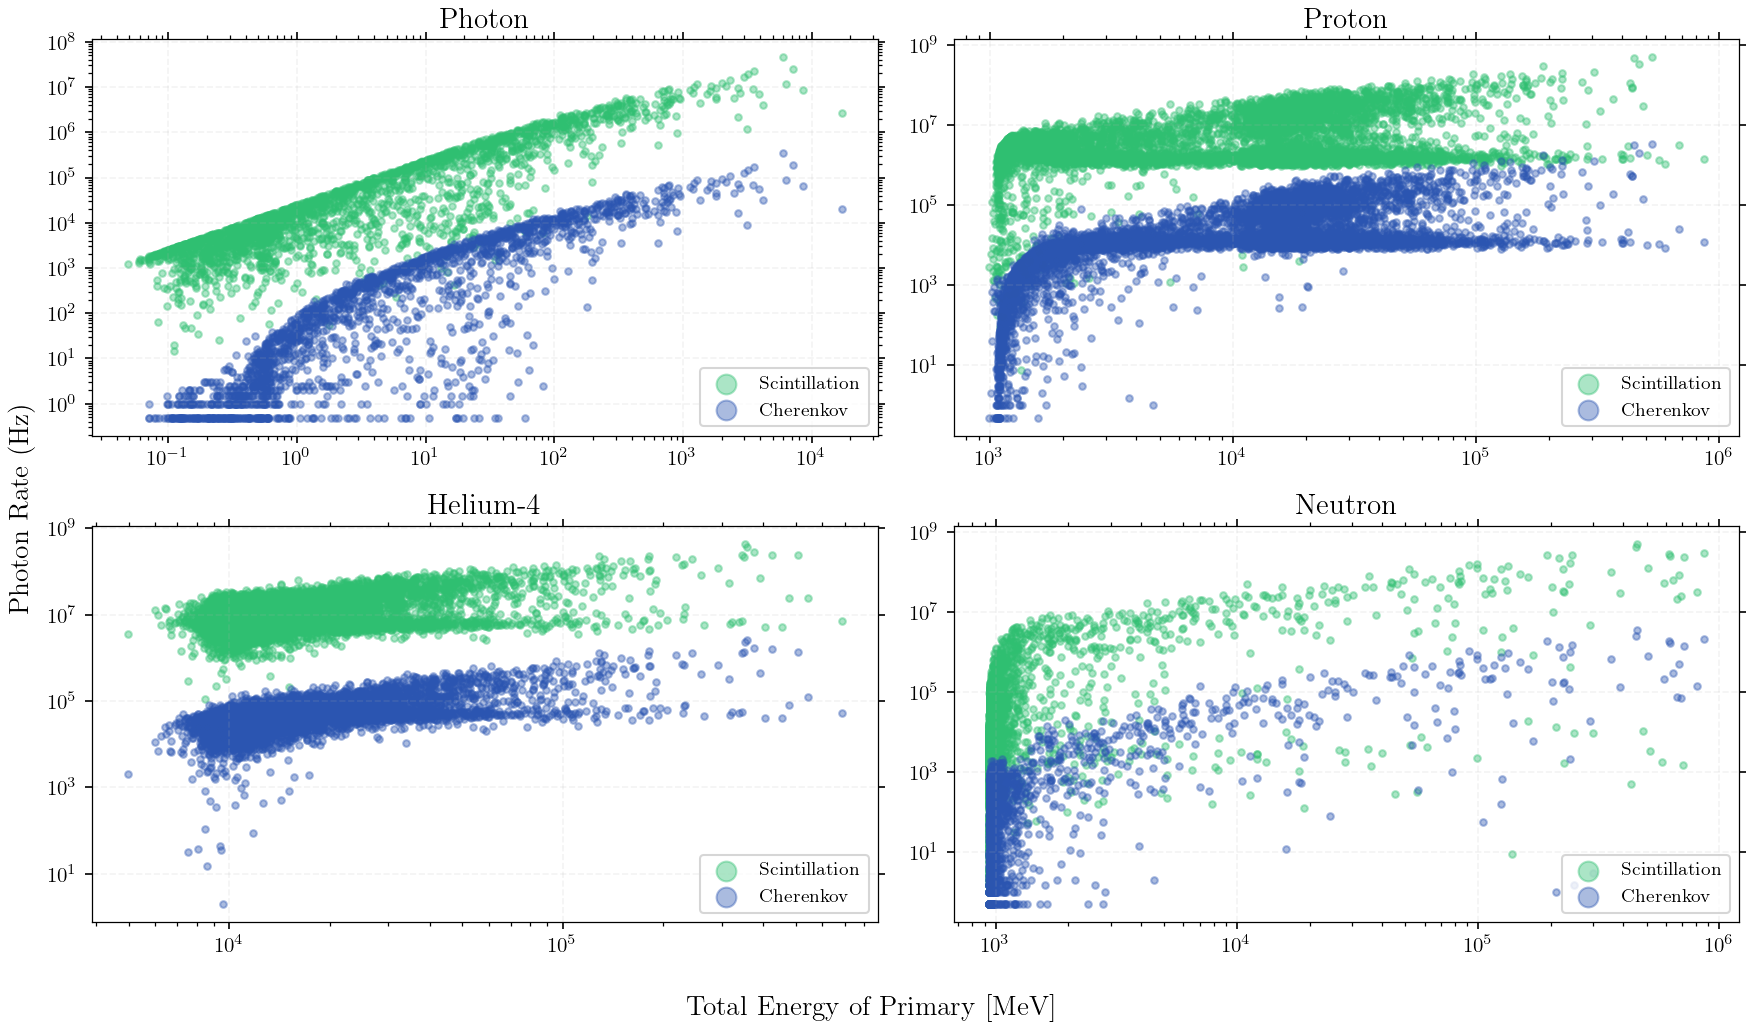

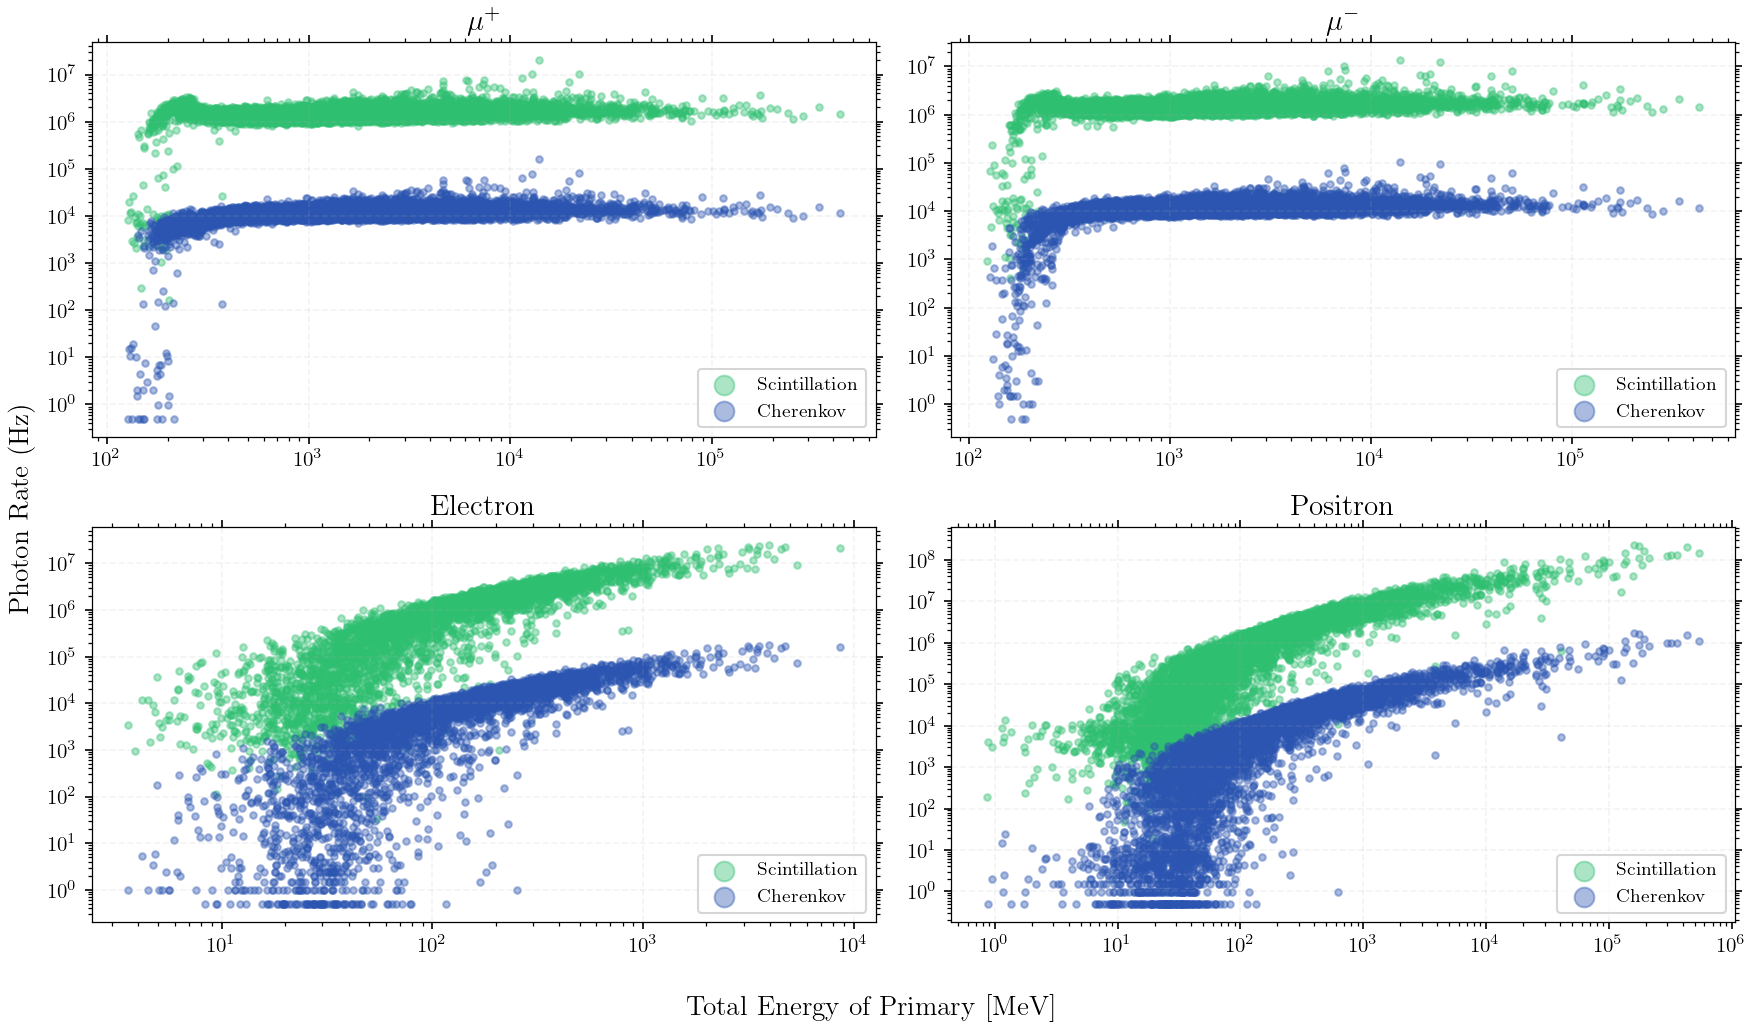

In [26]:
import numpy as np
import matplotlib.pyplot as plt

SCINT_COLOR = "#2FBF71"   # green
CER_COLOR   = "#2B55B1"   # blue

def plot_photon_grid(particle_list, data_source, weight_value, title, use_weighted=True):
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes = axes.flatten()

    for ax, p in zip(axes, particle_list):
        data = data_source.get(p, {})
        energies = np.asarray(data.get('energy', []))
        scint    = np.asarray(data.get('scint', []), dtype=float)
        cer      = np.asarray(data.get('cer', []), dtype=float)

        if use_weighted:
            weights = np.full_like(scint, fill_value=weight_value, dtype=float)
            scint = scint * weights
            cer   = cer * weights

        ax.scatter(energies, scint, alpha=0.4, s=10, label='Scintillation', color=SCINT_COLOR)
        ax.scatter(energies, cer,   alpha=0.4, s=10, label='Cherenkov',    color=CER_COLOR)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(particle_names.get(p, p))
        ax.grid(True, ls="--", alpha=0.15)
        ax.legend(loc='lower right', fontsize=9, markerscale=3)

    fig.supxlabel("Total Energy of Primary [MeV]")
    fig.supylabel("Photon Rate (Hz)")
    fig.tight_layout()
    plt.show()

weight_value = area * (1/T)

# --- Generate Plots ---
plot_photon_grid(group1, photon_data, weight_value, "Photon Yield", use_weighted=True)
plot_photon_grid(group2, photon_data, weight_value, "Photon Yield", use_weighted=True)
